# DL Assignment 2 | Generate Image Captions using CNN+LSTM usinng COCO dataset.

### Dataset -  
Common Objects in Context (COCO) --> https://www.kaggle.com/datasets/awsaf49/coco-2017-datasetLinks
* Please note that we have taken only a subset of data w.r.t dining table and cup classes to keep the training faster. We have limted GPU in Colab and we can not train on full dataset using free GPU of colab only.

### Install libraries
* Run below cell once to install all libraries.
* Upon installation of all libs, restart the runtime for libraries to be available for use.
* During subsequent executions, comment out below cell as libraries are already installed.

In [ ]:
# !pip install pycocotools
# !pip install keras
# !pip install tensorflow
# !pip install fiftyone

In [ ]:
# Import libraries for project

import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import random
import string
import cv2
import os
import json
import nltk
import tensorflow as tf
import fiftyone as fo
import fiftyone.zoo as foz
from pycocotools.coco import COCO 
from pickle import dump, load
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Input, Dropout, Attention
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, load_model
from tqdm.notebook import tqdm
from keras.layers import add  
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

Migrating database to v0.20.0


INFO:fiftyone.migrations.runner:Migrating database to v0.20.0


In [ ]:
# Download and import stopwords

nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Initialize global variables

pylab.rcParams['figure.figsize'] = (8.0, 10.0)
# classes = ["person"]  # We are using only subset of data. We are using 2 class data - Person and Car
classes = ["cup", "dining table"] 

### View dataset images in fiftyone app.
* View images in fifty one to get a generic idea on the dataset.
* We are only viewing the images with a mix of 2 classes - Car and Person

In [ ]:
# Download the required data - 500 images for viewing in fifty one app

dataset = foz.load_zoo_dataset(
    "coco-2017",
    splits=["validation","train"],
    classes=classes,
    max_samples=500,
)

INFO:fiftyone.zoo.datasets:Downloading split 'validation' to '/root/fiftyone/coco-2017/validation' if necessary


INFO:fiftyone.utils.coco:Downloading annotations to '/root/fiftyone/coco-2017/tmp-download/annotations_trainval2017.zip'


 100% |██████|    1.9Gb/1.9Gb [20.1s elapsed, 0s remaining, 107.1Mb/s]      


INFO:eta.core.utils: 100% |██████|    1.9Gb/1.9Gb [20.1s elapsed, 0s remaining, 107.1Mb/s]      


Extracting annotations to '/root/fiftyone/coco-2017/raw/instances_val2017.json'


INFO:fiftyone.utils.coco:Extracting annotations to '/root/fiftyone/coco-2017/raw/instances_val2017.json'


INFO:fiftyone.utils.coco:Downloading 500 images


 100% |██████████████████| 500/500 [4.9m elapsed, 0s remaining, 1.6 images/s]      


INFO:eta.core.utils: 100% |██████████████████| 500/500 [4.9m elapsed, 0s remaining, 1.6 images/s]      


Writing annotations for 500 downloaded samples to '/root/fiftyone/coco-2017/validation/labels.json'


INFO:fiftyone.utils.coco:Writing annotations for 500 downloaded samples to '/root/fiftyone/coco-2017/validation/labels.json'


INFO:fiftyone.zoo.datasets:Downloading split 'train' to '/root/fiftyone/coco-2017/train' if necessary


Found annotations at '/root/fiftyone/coco-2017/raw/instances_train2017.json'


INFO:fiftyone.utils.coco:Found annotations at '/root/fiftyone/coco-2017/raw/instances_train2017.json'


INFO:fiftyone.utils.coco:Downloading 500 images


 100% |██████████████████| 500/500 [5.1m elapsed, 0s remaining, 1.7 images/s]      


INFO:eta.core.utils: 100% |██████████████████| 500/500 [5.1m elapsed, 0s remaining, 1.7 images/s]      


Writing annotations for 500 downloaded samples to '/root/fiftyone/coco-2017/train/labels.json'


INFO:fiftyone.utils.coco:Writing annotations for 500 downloaded samples to '/root/fiftyone/coco-2017/train/labels.json'


Dataset info written to '/root/fiftyone/coco-2017/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/coco-2017/info.json'


Loading 'coco-2017' split 'validation'


INFO:fiftyone.zoo.datasets:Loading 'coco-2017' split 'validation'


 100% |█████████████████| 500/500 [4.2s elapsed, 0s remaining, 141.7 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 500/500 [4.2s elapsed, 0s remaining, 141.7 samples/s]      


Loading 'coco-2017' split 'train'


INFO:fiftyone.zoo.datasets:Loading 'coco-2017' split 'train'


 100% |█████████████████| 500/500 [6.3s elapsed, 0s remaining, 49.0 samples/s]       


INFO:eta.core.utils: 100% |█████████████████| 500/500 [6.3s elapsed, 0s remaining, 49.0 samples/s]       


Dataset 'coco-2017-validation-train-500' created


INFO:fiftyone.zoo.datasets:Dataset 'coco-2017-validation-train-500' created


In [ ]:
# Visualize the dataset in the FiftyOne App to get an idea about data
# session = fo.launch_app(dataset)

# This step is just for us to visualize images and have been ignored for display during final execution to save time.

### Data Processing
#### Reference Assignment Question - Load the data into train and test data in the required format
1. Load annotation files for both train and validation set
2. Create an object to understand the classes and the number of images containing these classes.
3. Create an object to show images containing an intersection of classes used for project - person and car
4. Follow step 1 and 2 for both train and validation set
5. Load captions file for both train and validation sets

In [ ]:
# initialize COCO api for instance annotations for train and validation set

file='/root/fiftyone/coco-2017/raw/instances_train2017.json'
coco=COCO(file)

file_val = '/root/fiftyone/coco-2017/raw/instances_val2017.json'
coco_val = COCO(file_val)

loading annotations into memory...
Done (t=17.43s)
creating index...
index created!
loading annotations into memory...
Done (t=0.51s)
creating index...
index created!


In [ ]:
# Create a dictionary "subcategories_imageIds" containing the category ID and category name.

def cat_with_image_id(subcategories_imageIds, coco, catIds):
  for i in range(0,len(catIds)):
      imgIds = coco.getImgIds(catIds=catIds[i])
      img = []
      for j in imgIds: 
          img.append(j)
      subcategories_imageIds[classes[i]] = img
  return subcategories_imageIds

catIds = coco.getCatIds(catNms=classes)  
subcategories_imageIds = dict()
subcategories_imageIds = cat_with_image_id(subcategories_imageIds, coco, catIds)
print("Sub categories in train set with Image IDs :",len(subcategories_imageIds))

catIds_val = coco_val.getCatIds(catNms=classes)  
subcategories_imageIds_val = dict()
subcategories_imageIds_val = cat_with_image_id(subcategories_imageIds_val, coco_val, catIds_val)
print("Sub categories in validation set with Image IDs :",len(subcategories_imageIds_val))

Sub categories in train set with Image IDs : 2
Sub categories in validation set with Image IDs : 2


In [ ]:
# Create a dictionary "length_dict" conainng category name and total images inside that category

length_dict = {key: len(value) for key, value in subcategories_imageIds.items()}
print("Total images in train set in each sub categories: ", length_dict)

length_dict_val = {key: len(value) for key, value in subcategories_imageIds_val.items()}
print("Total images in validation set in each sub categories: ", length_dict_val)

Total images in train set in each sub categories:  {'cup': 9189, 'dining table': 11837}
Total images in validation set in each sub categories:  {'cup': 390, 'dining table': 501}


In [ ]:
# Images containing intersection of classes - person and car. Get all images containing the above Category ID's for train and validation set

imgIdss = coco.getImgIds(catIds=coco.getCatIds(catNms=classes))
print("Number of images containing all the classes in train set:", len(imgIdss))

imgIdss_val = coco_val.getImgIds(catIds=coco_val.getCatIds(catNms=classes))
print("Number of images containing all the classes in validation set:", len(imgIdss_val))

Number of images containing all the classes in train set: 4679
Number of images containing all the classes in validation set: 194


In [ ]:
# Load images with captions for train and validation set

file='/root/fiftyone/coco-2017/raw/captions_train2017.json'
coco_caps=COCO(file)

file_val='/root/fiftyone/coco-2017/raw/captions_val2017.json'
coco_caps_val=COCO(file_val)

loading annotations into memory...
Done (t=1.09s)
creating index...
index created!
loading annotations into memory...
Done (t=0.07s)
creating index...
index created!


### Data Processing
#### Rereference Assignment Question - Plot at least two samples and their captions

* Visualize image from the train dataset along with the captions.
* Visualize image from the validation dataset along with the captions.

A chef in a kitchen preparing a meal.
A cook stands at the counter with a cutting board and salad tongs in front of him.
Chef talking to people seated at a bar in kitchen with various food items.
A man in a kitchen preparing food with people sitting at the counter.
A cook doing a demonstration of something in front of other people.


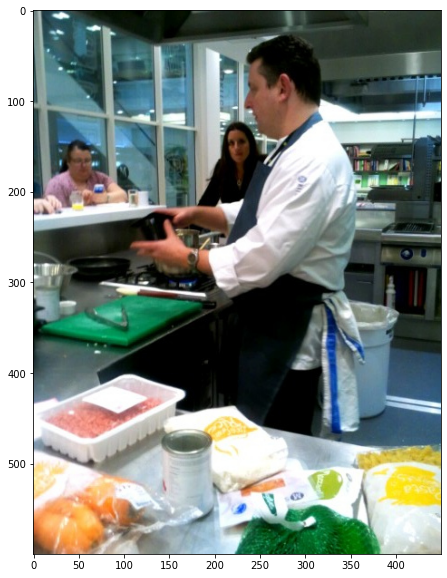

In [ ]:
# Visualize an image along with its captions from train set

img = coco.loadImgs(imgIdss[1])[0]
I = io.imread(img['coco_url'])
plt.imshow(I)
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)
plt.show()

A girl with some food and drink at a table.
A YOUNG GIRL EATING PIZZA DRESSED AS A EGYPTION
A girl sitting around a table in a restaurant eating a pizza.  
A young girl eating pizza in a restaurant.
A girl in a Cleopatra outfit eating pizza at a table.


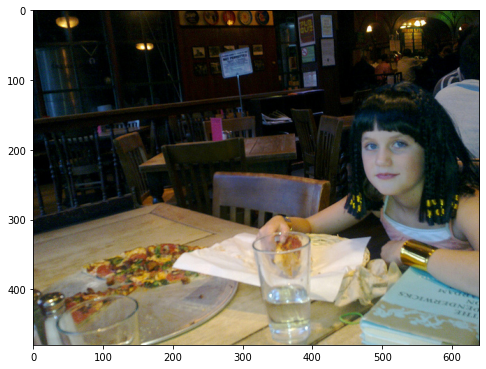

In [ ]:
# Visualize an image along with its captions from validation set

img = coco_val.loadImgs(imgIdss_val[1])[0]
I = io.imread(img['coco_url'])
plt.imshow(I)
annIds = coco_caps_val.getAnnIds(imgIds=img['id']);
anns = coco_caps_val.loadAnns(annIds)
coco_caps_val.showAnns(anns)
plt.show()

### Data Processing
1. Make dataset dictionary object containing image and its corresponding captions.
2. Make sure to clean up captions using techniques such as removing punctuation, converting to lowercase etc.
3. Make sure to add start and end tag to each caption for model to understand beginning and ending of sentence.
4. The dataset object has to be created for both train and validation sets.
5. Example of dataset object - Dataset is a dictionary with structure as given in below. 

'http://images.cocodataset.org/train2017/000000360452.jpg': 
 ['<start> a young man holding a baseball bat in front of a ball <end>',
  '<start> a young person swinging a baseball bat at a ball <end>',
  '<start> child swinging bat playing baseball with adult watching and fence <end>',
  '<start> a boy hitting a ball with his bat on the baseball field <end>',
  '<start> a young boy takes a swing at a ball with his baseball bat <end>']

In [ ]:
# Make a "dataset" containing image and its captions and make sure to clean up captions using basic NLP techniques.

def dataset_creation(imgIdss, coco, coco_caps):
  dataset = dict()
  imgcaptions = []

  for imgid in imgIdss:
      img = coco.loadImgs(imgid)[0]
      annIds = coco_caps.getAnnIds(imgIds=img['id']);
      anns = coco_caps.loadAnns(annIds)
      imgcaptions = []
      for cap in anns:
          
          # Remove punctuation
          cap = cap['caption'].translate(str.maketrans('', '', string.punctuation))
          
          # Replace - to blank
          cap = cap.replace("-"," ")
          
          # Split string into word list and Convert each word into lower case
          cap = cap.split()
          cap = [word.lower() for word in cap]
          
          # join word list into sentence and <start> and <end> tag to each sentence which helps 
          # LSTM encoder-decoder model while training.
          cap = '<start> ' + " ".join(cap) + ' <end>' 
          imgcaptions.append(cap)
          
      dataset[img['coco_url']] = imgcaptions 
  return dataset

dataset = dataset_creation(imgIdss, coco, coco_caps)
print("Length of Training Dataset: ",len(dataset), "\n")

dataset_val = dataset_creation(imgIdss_val, coco_val, coco_caps_val)
print("Length of Validation Dataset: ",len(dataset_val), "\n")

Length of Training Dataset:  4679 

Length of Validation Dataset:  194 



### Data Preprocessing
1. Training dataset object - Create tokenizer object from training dataset object. The tokenizer object is just a integer mapping of all words in vocabulary.
2. Training dataset object - Calculate the maximum possible length of a caption in training dataset object. This is required to do padding of captions which are of length lesser than maximum length.

In [ ]:
# Process and tokenize captions

from itertools import chain
flatten_list = list(chain.from_iterable(dataset.values())) 

tokenizer = Tokenizer(oov_token='<oov>') # For those words which are not found in word_index
tokenizer.fit_on_texts(flatten_list)
total_words = len(tokenizer.word_index) + 1

print("Vocabulary length: ", total_words)
print("chair ID: ", tokenizer.word_index['microwave'])
print("car ID: ", tokenizer.word_index['apple'])

Vocabulary length:  5192
chair ID:  530
car ID:  427


In [ ]:
# Find max length in captions that will aid in padding

def max_length_master(dataset):
  def dict_to_list(descriptions):
      all_desc = []
      for key in descriptions.keys():
          [all_desc.append(d) for d in descriptions[key]]
      return all_desc

  def max_length(descriptions):
      desc_list = dict_to_list(descriptions)
      return max(len(d.split()) for d in desc_list)
    
  return max_length(dataset)
    
max_length = max_length_master(dataset)
print(max_length)

# max_length means the maximum number of tokens that are available in a caption including <start> and <end>

49


### Model Building - Image Feature Extraction
#### Reference Assignment Question - Use any pretrained model trained on ImageNet dataset (available publicly on google) for image feature extraction. 

* Extract image features using Xception model which is pretrained on imagenet.
* Here, the Xception model takes 299 x 299 x 3 image size as input. 
* We will remove the last classification layer and get the 2048 feature vector.
* Image feature extraction is done for both training and validation set.

In [ ]:
model = Xception(include_top=False, pooling='avg')

def get_image_features(dataset):
  image_features = {}

  for img in tqdm(dataset.keys()):
      image = io.imread(img)
      if image.ndim != 3:  # convert image to 3 layers since thats what is required by model
          image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
      
      # Resize each image size 299 x 299 
      image = cv2.resize(image,(299,299))
      image = np.expand_dims(image, axis=0)
      
      # Normalize image pixels
      image = image/255 
      image = image - 1.0

      # Extract features from image
      feature = model.predict(image)
      image_features[img] = feature
  return image_features

image_features = get_image_features(dataset)
image_features_val = get_image_features(dataset_val)

print("Image features length: ", len(image_features))
print("Image features length for val: ", len(image_features_val))

83683744/83683744 [==============================] - 4s 0us/step


  0%|          | 0/4679 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


  0%|          | 0/194 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step
Image features length:  4679
Image features length for val:  194


### Data Processing - Data Generator for Model Input
#### Reference Assignment Question - Convert the data into the correct format which could be used for the DL model.

* We have to train our model on high number of images and each image will contain 2048 length feature vector. 
* The caption is represented as numbers using tokenizer. 
* Since the dataset is very large,it is not possible to hold into memory so we will be using a generator method that will yield batches.
* The generator will yield the input and output sequence.
* The input to our model is [x1, x2] and the output will be y, where x1 is the 2048 feature vector of that image, x2 is the input text sequence and y is the output text sequence that the model has to predict.

In [ ]:
#create input-output sequence pairs from the image description. 

def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
      for key, description_list in descriptions.items():
          feature = features[key][0]
          input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)  # desc list is a list containing all captions for each image
          yield ([input_image, input_sequence], output_word)            

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    
    # walk through each description for the image
    for desc in desc_list:
        
        # encode the sequence
        # example data for below command- seq [3, 2, 22, 12, 1, 154, 10, 68, 4] for ["<start> a microwave is seen near the fridge <end>"]
        seq = tokenizer.texts_to_sequences([desc])[0]  

        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            
            # split into input and output pair
            # example data for below command - # seq_test, seq_test[:2], seq_test[2]  # ([3, 2, 22, 12, 1, 154, 10, 68, 4], [3, 2], 22)
            in_seq, out_seq = seq[:i], seq[i]  
            
            # pad input sequence
            # example data for below command - # pad_sequences([seq_test[:2]], maxlen=33)[0]  # array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2], dtype=int32)
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]  
            
            # encode output sequence
            # example data for below command - # out_seq becomes an array with only those item 1 which is there in out_seq rest are 0. it is a array of same size as total_words ~ vocab size
            out_seq = to_categorical([out_seq], num_classes=total_words)[0]  
            
            # store
            X1.append(feature) # image features
            X2.append(in_seq)  # Caption input
            y.append(out_seq)  # Caption output

    return  np.array(X1), np.array(X2), np.array(y)

### Model Building - CNN-LSTM model
* CNN is used for extracting features from the image. We will use the pre-trained model Xception.
* LSTM will use the information from CNN to help generate a description of the image.

#### Reference Assignment Questions below.
1. Create a 2 layer LSTM model and other relevant layers for image caption generation.
    * The details of model are given in below cell with inline comments.
2. Add one layer of dropout at the appropriate position and give reasons. 
    * The details of drop out and its usage within the model are given in below cell with inline comments.
3. Choose the appropriate activation function for all the layers. 
    * Tanh activation - tanh activation used in LSTM. There is also another important activation called sigmoid that's used in multiple models but we are avoiding that here to avoid vanishing grad issue that happen due to sigmoid.
    * Softmax in output layer - used softmax activation in output to generate a relative probability of generation of each word in output

4. Print the model summary. 
    * Model summary is printed in the output of below cell
5. Justify the choice of number of layers, activation function and any other hyper parameters used.
    * We have provided justification of layers using inline comments. The use of activation is already explained in point 3.
6. Compile the model with the appropriate loss function. 
    * Model compiled as shown in below cell.
7. Use an appropriate optimizer. 
    * Refer below cell
8. Justify the choice of learning rate, optimizer, loss function and any other hyper parameter used.
    * We tried RMSPROP here since we do not see any sparse column in input which would have triggered usage of Adam optimizer. RMS Prop is an improvement over adagrad and gives more importance to the latest gradients. RMSPROP did not work well as compared to Adam due to which we shifted to Adam optimizer. RMSPROP was moving extremely slow and was almost working snail pace.


In [ ]:
from tensorflow.keras import regularizers

# define the captioning model
def define_model(total_words, max_length):

    # features from the CNN model squeezed from 2048 to 256 node
    inputs1 = Input(shape=(2048,))  # 2048 dim vector from Xception model
    fe1 = Dropout(0.3)(inputs1)  # we generally do a drop out in the complex layers. Here the input is 2048 dim vector  
    ## which is very high dimension data. Hence, to simplify the layer and do regularization, we apply dropout here.
    fe2 = Dense(256, activation='relu')(fe1)  # squeezing to 256 dim to match the 256 dimension output from LSTM sequence

    # LSTM sequence model
    ## Embedding layer is used in beginning to convert string input into a numerical embedding vector format
    ## LSTM - 2 layers of LSTM added to the model as asked in question and are used as well.
    inputs2 = Input(shape=(max_length,))  
    se1 = Embedding(total_words, 256, mask_zero=True)(inputs2)  # this layer is put in place to get numerical embedding for the input text
    se2 = LSTM(256, return_sequences=True, activation = 'tanh', recurrent_dropout=0.3)(se1) # we have put 2 LSTM as required in assignment.
    se3 = LSTM(256, activation = 'tanh', recurrent_dropout=0.3)(se2) # we added dropout in 2 LSTM layers to avoid overfitting.
  
    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)  # adding one layer after merging lstm and cnn output to generalize 
    outputs = Dense(total_words, activation='softmax')(decoder2) 

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')  

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

### Model Training
#### Reference Assignment Questions
1. Train the model for an appropriate number of epochs. 
    * Trained the model for 3 epochs with early stopping setup on loss
2. Print the train and validation loss for each epoch. Use the appropriate batch size.
    * Train and validation loss is printed in the graph.
3. Plot the loss and accuracy history graphs for both train and validation set. 
    * Loss curve is plotted from history object. Accuracy is not valid KPI for this use case since Accuracy is used more often in classification kind of problems.
4. Print the total time taken for training.
    * Time is printed in output of below cell.

In [ ]:
import time
import sys
from keras.callbacks import EarlyStopping

# train our model
print('Dataset: ', len(dataset), " dataset val: ",len(dataset_val))
print('Descriptions: train=', len(dataset))
print('Photos: train=', len(image_features), " val= ", len(image_features_val))
print('Vocabulary Size:', total_words)
print('Description Length: ', max_length)

model = define_model(total_words, max_length)
epochs=1
steps = len(dataset)
steps_val = len(dataset_val)

# making a directory models to save our models
import os
try:
  os.mkdir("models")
except FileExistsError:
  pass

start_time = time.time()
for i in range(epochs):
  generator = data_generator(dataset, image_features, tokenizer, max_length)  
  generator_val = data_generator(dataset_val, image_features_val, tokenizer, max_length) 
  es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1)
  history = model.fit(generator, epochs=10, callbacks=[es], steps_per_epoch= steps, verbose=1,validation_data=generator_val, validation_steps=steps_val)  # history = 
  model.save("models/model_" + str(i) + ".h5")

print("Total time taken for training is %s seconds." % (time.time() - start_time))

Dataset:  4679  dataset val:  194
Descriptions: train= 4679
Photos: train= 4679  val=  194
Vocabulary Size: 5192
Description Length:  49


Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 49)]         0           []                               
                                                                                                  
 input_34 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 embedding_16 (Embedding)       (None, 49, 256)      1329152     ['input_35[0][0]']               
                                                                                                  
 dropout_25 (Dropout)           (None, 2048)         0           ['input_34[0][0]']               
                                                                                           

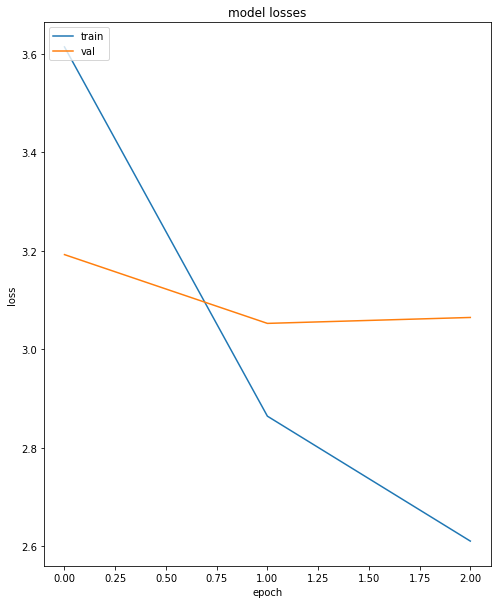

In [ ]:
# Loss curve

import keras
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model losses')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# Save the model

model.save("models/model_0.h5")

### Model Evaluation
#### Questions from Assignment
1. Take 5 random images from Google and generate caption for that image. 
    * It is done in cells to follow.
2. Print confusion metrics and classification report for the test data. 
    * Confusion metrics and classification report are used for classification use case. We do not have a classification case.

In [ ]:
# Load images for inference

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import urllib.request  
  
def extract_features(filename, model):
        try:
            image = Image.open(filename)

        except:
            print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
        image = image.resize((299, 299)) 
        image = np.array(image)
        
        # for images that has 4 channels, we convert them into 3 channels
        if image.shape[2] == 4: 
            image = image[..., :3]
        image = np.expand_dims(image, axis=0)
        image = image/255  
        image = image - 1.0
        feature = model.predict(image)
        return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None


def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        
        if word is None:
            break
        in_text += ' ' + word
        
        if word == 'end':
            break
    return in_text

model = load_model('./models/model_0.h5')
xception_model = Xception(include_top=False, pooling='avg')

### Images for inference
* The images taken from net are related to kitchen/cooking/eating etc as our input classes were dining table and cup and their images would be restricted to these areas only. We can not feed random images to model as it is trained only on a subset of coco dataset.

1/1 [==============================] - 0s 25ms/step



generated caption from model is - a man sitting at a table with a plate of food


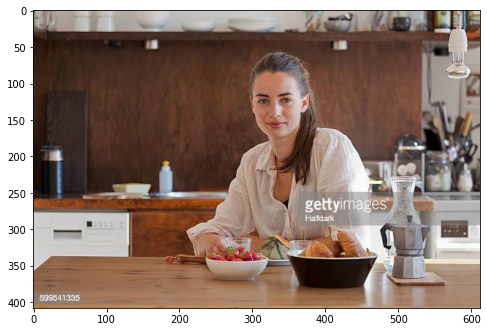

In [ ]:
# Inference for Images from Internet

urllib.request.urlretrieve(
  'https://media.gettyimages.com/id/599541335/photo/young-woman-sitting-at-dining-table-portrait.jpg?s=612x612&w=gi&k=20&c=pUBHsSLX0hZO2hOHxkLCUxfIAE6WD3PqRpKDQZ6oU8k=',
   "image_100.png")
photo = extract_features("image_100.png", xception_model)  # vgg_model
img = Image.open("image_100.png")
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
description = description[6:]
description = description[:-4]
print("generated caption from model is -", description)
plt.imshow(img)

1/1 [==============================] - 0s 24ms/step



generated caption from model is - a table with a variety of food on it


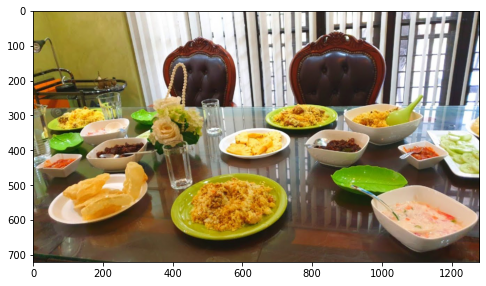

In [ ]:
# Inference for Images from Internet

urllib.request.urlretrieve(
"https://i.ytimg.com/vi/lFyA6rL_cSY/maxresdefault.jpg",
   "image_101.png")

photo = extract_features("image_101.png", xception_model)
img = Image.open("image_101.png")
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
description = description[6:]
description = description[:-4]
print("generated caption from model is -", description)
plt.imshow(img)

1/1 [==============================] - 0s 49ms/step



generated caption from model is - a kitchen with a table and a table with a lot of food


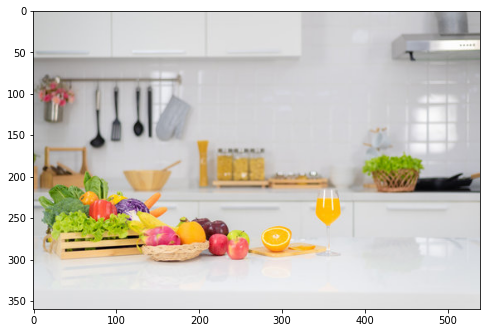

In [ ]:
# Inference for Images from Internet

urllib.request.urlretrieve(
"https://t3.ftcdn.net/jpg/02/78/19/58/360_F_278195824_10YfZufo5OeAU2LdD4ya47DcIwELf09X.jpg",
   "image_102.png")

photo = extract_features("image_102.png", xception_model)
img = Image.open("image_102.png")
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
description = description[6:]
description = description[:-4]
print("generated caption from model is -", description)
plt.imshow(img)

1/1 [==============================] - 0s 47ms/step



generated caption from model is - a group of people sitting at a table with a meal


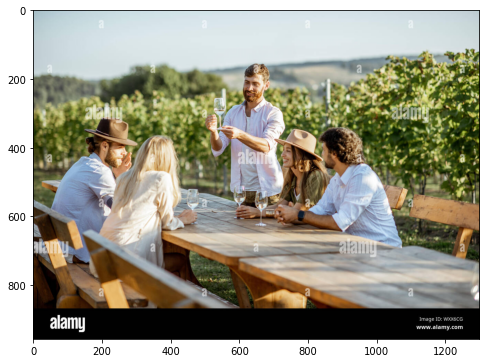

In [ ]:
# Inference for Images from Internet

urllib.request.urlretrieve(
"https://c8.alamy.com/comp/WXX6CG/group-of-a-young-people-drinking-wine-and-talking-together-while-sitting-at-the-dining-table-outdoors-on-the-vineyard-on-a-sunny-evening-WXX6CG.jpg", "image_103.png")

photo = extract_features("image_103.png", xception_model)
img = Image.open("image_103.png")
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
description = description[6:]
description = description[:-4]
print("generated caption from model is -", description)
plt.imshow(img)

1/1 [==============================] - 0s 89ms/step



generated caption from model is - a woman is eating a piece of pizza


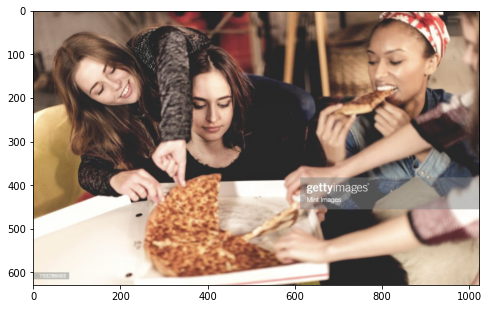

In [ ]:
# Inference for Images from Internet

urllib.request.urlretrieve(
"https://media.gettyimages.com/id/753288583/photo/four-young-women-sitting-round-a-table-eating-pizza.jpg?s=1024x1024&w=gi&k=20&c=z8-uNN7_bUYfnthzUX5h6l7qN0y0LpR2Sz8QDssCs1E=",
   "image_104.png")

photo = extract_features("image_104.png", xception_model)
img = Image.open("image_104.png")
description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
description = description[6:]
description = description[:-4]
print("generated caption from model is -", description)
plt.imshow(img)

## Conclusions

1. VGG 16 model was used in first iteration to extract image features. It lead to the model not able to learn much and then we had to move to a complex Xception model for image feature extraction.
2. Data formatting required for the final model was done using basic python object that contains all data together at once. This lead to issues since the model requires iterator object. Data iterator object was used to generate data in required format during second attempt.
3. Selection of a subset of data that contains good amount of images in train and validation was a challenge. After multiple iterations, we choose "cup" and "duning table" dataset that contains close to 5k images.
4. Training time was another challenge which was tackled by using free GPU from kaggle and colab.
5. We tried multiple optimizers including RMSPROP and Adam. RMSProp was not at all concluding and we choose Adam instead.
6. Hyperparameter and tuning - We tried multiple techniques for regularization like L2, L1 and drop out. We finally selected drop out as the generalization techniques as it lead to better results amoung all.
7. The use case is not related to classification and hence, measures like "accuracy" and "classification report" will not make sense and hence, those are not covered here.